In [ ]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 10.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier, PassiveAggressiveClassifier, Perceptron
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, HistGradientBoostingClassifier, StackingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sentence_transformers import SentenceTransformer
import re
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.corpus import stopwords as nltk_stopwords
import nltk
from collections import Counter

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def cleaning_data(text):
    # --- Extract bagian komplain dari email ---
    if not isinstance(text, str):
        return "Bagian komplain tidak ditemukan."

    start_patterns = [
        r"(?i)perhatian:\s*e-?mail ini berasal dari pihak di luar OJK\.?\s*harap waspada ketika akan membuka lampiran.*?tautan.*?e-?mail ini\.?",
        r"(?i)peringatan\s*:?\s*e-?mail ini mengandung URL tidak dikenal dan berpotensi bahaya\.?\s*jangan membuka URL tersebut, kecuali Anda yakin dengan isinya\.?"
    ]

    start_match = None
    for pattern in start_patterns:
        matches = list(re.finditer(pattern, text, re.DOTALL))
        if matches:
            start_match = matches[-1].end()

    if start_match:
        text = text[start_match:].strip()

    end_patterns = [
        r"(?i)best regards", r"(?i)warm regards", r"(?i)regards",
        r"(?i)hormat kami", r"(?i)salam hormat", r"(?i)demikian.*",
        r"(?i)from: .*", r"(?i)call center", r"(?i)visit our website"
    ]

    for pattern in end_patterns:
        match = re.search(pattern, text, re.DOTALL)
        if match:
            text = text[:match.start()]
            break

    sensitive_info_patterns = [
        r"(?i)Nama\s*Perusahaan\s*.*", r"(?i)Nama\s*Pelapor\s*.*", r"(?i)Nama\s*BPR\s*.*",
        r"(?i)No\.\s*Surat\s*.*", r"(?i)Nama\s*Bank\s*.*", r"(?i)Nama\s*KAP\s*.*",
        r"(?i)NPWP\s*Perusahaan\s*.*", r"(?i)Nama\s*File\s*.*", r"(?i)No\.\s*Telp\s*.*",
        r"(?i)No\.\s*Telp\s*Pelapor\s*.*", r"(?i)Nama\s*Terdaftar\s*.*"
    ]
    for pattern in sensitive_info_patterns:
        text = re.sub(pattern, "", text)

    text = re.sub(r"\s+", " ", text).strip()

    # --- Filter keyword spam dan basa-basi ---
    keywords = [
        "terlampir", "mohon bantuan", "terima kasih", "yth", "assalamualaikum", "wabarakatuh",
        "warahmatullahi", "dear", "salam hormat", "selamat", "pagi", "siang", "berikut", "no2",
        "BaI", "rl008", "atas bantuan", "sore", "malam", "kepada", "direktur", "pelaporan data",
        "departemen", "apoloojkgoid", "semoga", "atas kendala", "pengelolaan data", "dan statistik",
        "menara radius prawiro", "lantai 14", "wassalamu", "alaikum", "hormat", "komplek perkantoran",
        "bank indonesia", "jl", "mh thamrin", "jakarta pusat", "10350", "sampaikan", "helpdesk",
        "otoritas jasa keuangan", "laporan", "apolo", "terimakasih", "mohon", "apollo", "hari", "slik",
        "senin", "selasa", "rabu", "kamis", "jumat", "sabtu", "minggu", "2024", "2025", "https", "sipeduli",
        "assalamu", "alaikum", "bpr", "bank", "perusahaan", "perkenalkan", "team", "bersama", "aplikasi", "bapak", "ibu"
    ]
    pattern = r"(?i)\b(" + "|".join(re.escape(k) for k in keywords) + r")\b"
    text = re.sub(pattern, "", text)

    # --- Hapus email dan nomor telepon ---
    text = re.sub(r"\b[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,}\b", "", text, flags=re.IGNORECASE)
    text = re.sub(r"(?i)\b(\+62|62|0)?[-.\s]?(\d{2,4}[-.\s]?){2,4}\d{2,4}\b", "", text)

    # --- Normalisasi teks ---
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    # --- Stopword removal ---
    stopword_factory = StopWordRemoverFactory()
    sastrawi_stop = set(stopword_factory.get_stop_words())
    nltk_stop = set(nltk_stopwords.words("english"))
    combined_stopwords = sastrawi_stop | nltk_stop
    custom_keep = {"tidak", "belum", "bisa", "akses", "login", "ada", "error", "gagal"}
    final_stopwords = combined_stopwords - custom_keep

    words = [w for w in text.split() if w not in final_stopwords and len(w) > 2]
    text = ' '.join(words)

    # --- Normalisasi sinonim kata umum ---
    replacements = {
        r"\bmasuk\b": "login",
        r"\blog-in\b": "login",
        r"\brenbis\b": "rencana bisnis",
        r"\bapkap\b": "ap kap",
        r"\baro\b": "administrator responsible officer",
        r"\bro\b": "responsible officer",
        r"\bmengunduh\b": "download",
        r"\bunduh\b": "download",
        r"\bcondense\b": "condensed",
        r"\blap0ran\b": "laporan",
        r"\bsandi\b": "password",
        r"\bisidental\b": "insidental"
    }

    for pattern, repl in replacements.items():
        text = re.sub(pattern, repl, text)

    # Final cleanup
    text = re.sub(r"\s+", " ", text).strip()
    return text if text else "Bagian komplain tidak ditemukan."

In [ ]:
def cleaning_data_erep(text):
    if not isinstance(text, str):
        return "Bagian komplain tidak ditemukan."

    # --- Step 1: Hapus frasa sapaan spesifik ---
    text = re.sub(r"Dear\s*Bapak/Ibu\s*Helpdesk\s*OJK", "", text)

    # --- Step 2: Extract bagian komplain ---
    start_patterns = [
        r"PERHATIAN: E-mail ini berasal dari pihak di luar OJK.*?attachment.*?link.*?yang terdapat pada e-mail ini."
    ]
    end_patterns = [
        r"(From\s*.*?From|Best regards|Salam|Atas perhatiannya|Regards|Best Regards|Mohon\s*untuk\s*melengkapi\s*data\s*.*tabel\s*dibawah).*",
        r"From:\s*Direktorat\s*Pelaporan\s*Data.*"
    ]

    start_match = None
    for pattern in start_patterns:
        matches = list(re.finditer(pattern, text, re.DOTALL))
        if matches:
            start_match = matches[-1].end()

    if start_match:
        text = text[start_match:].strip()

    for pattern in end_patterns:
        end_match = re.search(pattern, text, re.DOTALL)
        if end_match:
            text = text[:end_match.start()].strip()

    # --- Step 3: Hapus informasi sensitif ---
    sensitive_info_patterns = [
        r"Nama\s*Terdaftar\s*.*",
        r"Email\s*.*",
        r"No\.\s*Telp\s*.*",
        r"User\s*Id\s*/\s*User\s*Name\s*.*",
        r"No\.\s*KTP\s*.*",
        r"Nama\s*Perusahaan\s*.*",
        r"Nama\s*Pelapor\s*.*",
        r"No\.\s*Telp\s*Pelapor\s*.*",
        r"Internal",
        r"Dengan\s*hormat.*",
        r"Jenis\s*Usaha\s*.*",
        r"Keterangan\s*.*",
        r"No\.\s*SK\s*.*",
        r"Alamat\s*website/URL\s*.*",
        r"Selamat\s*(Pagi|Siang|Sore).*",
        r"Kepada\s*Yth\.\s*Bapak/Ibu.*",
        r"On\s*full_days\s*\d+\d+,\s*\d{4}-\d{2}-\d{2}\s*at\s*\d{2}:\d{2}.*",
        r"Dear\s*Bapak/Ibu\s*Helpdesk\s*OJK.*",
        r"No\.\s*NPWP\s*Perusahaan\s*.*",
        r"Aplikasi\s*OJK\s*yang\s*di\s*akses\s*.*",
        r"Yth\s*.*",
        r"demikian\s*.*",
        r"Demikian\s*.*",
        r"Demikianlah\s*.*"
    ]
    for pattern in sensitive_info_patterns:
        text = re.sub(pattern, "", text)

    # --- Step 4: Bersihkan spam dan noise umum ---
    spam_patterns = [
        r"(?i)(terlampir|mohon\s*bantuan|terima\s*kasi|yth|daripada\s*\w+\s*\@.*?\.com)",
        r"(?i)Selamat\s*.*",
        r"(?i)Dear\s*(Bapak/Ibu\s*)?Helpdesk\s*OJK",
        r"(?i)Dear\s*Helpdesk",
        r"(?i)Mohon\s*bantuannya",
        r"(?i)Terimakasih",
        r"(?i)Hormat\s*kami",
        r"(?i)Regard",
        r"(?i)Atas\s*perhatian\s*dan\s*kerja\s*samanya",
        r"(?i)Dengan\s*hormat",
        r"(?i)Perhatian",
        r"(?i)Caution",
        r"(?i)Peringatan",
        r"(?i)Harap\s*diperhatikan",
        r"(?i)Terlampir",
        r"(?i)Mohon\s*kerjasamanya",
        r"(?i)Mohon\s*informasi",
        r"(?i)Sehubungan\s*dengan",
        r"(?i)Kepada",
        r"(?i)Kami\s*moho",
        r"(?i)Terkait",
        r"(?i)Berikut\s*kami\s*sampaikan",
        r"(?i)Jika\s*Anda\s*bukan\s*penerima\s*yang\s*dimaksud",
        r"(?i)Email\s*ini\s*hanya\s*ditujukan\s*untuk\s*penerima",
        r"(?i)Mohon\s*segera\s*memberitahukan\s*kami",
        r"(?i)Jika\s*Anda\s*memerima\s*ini\s*secara\s*tidak\s*seganja",
        r"(?i)Mohon\s*dihapus",
        r"(?i)Kami\s*mengucapkan\s*terima\s*kasi",
        r"(?i)Mohon\s*perhatian",
        r"(?i)From\s*.*",
        r"(?i):\s*e-Mail\s*ini\s*termasuk\s∗seluruh\s∗lampirannya.*",
        r"(?i):\s*This\s*electronic\s*mail\s*.*Jasa\s*Raharja.*",
        r"(?i)PT\.\s*Jasa\s*Raharja\s*tidak\s*bertanggung\s*jawab.*",
        r"(?i)Jika\s*Anda\s*secara\s*tidak\s*seganja\s*menerima\s*e-Mail\s*ini\s*,.*",
        r"(?i)\s*Please\s*reply\s*to\s*this\s*electronic\s*mail\s*.*"
    ]
    for pattern in spam_patterns:
        text = re.sub(pattern, "", text)

    # --- Step 5: Cut-off berdasarkan keyword panjang (kasus umum) ---
    cut_off_keywords = [
        "PT Mandiri Utama FinanceSent: Wednesday, November 6, 2024 9:11 AMTo",
        "Atasdan kerjasama, kami ucapkan h Biro Hukum dan KepatuhanPT Jasa Raharja (Persero)Jl. HR Rasuna Said Kav. C-2 12920Jakarta Selatan",
        "h._________",
        "h Imawan FPT ABC Multifinance Pesan File Kirim (PAPUPPK/2024-12-31/Rutin/Gagal)Kotak MasukTelusuri semua pesan berlabel Kotak MasukHapus",
        "KamiBapak/Ibu untuk pencerahannya",
        "kami ucapkan h. ,",
        "-- , DANA PENSIUN BPD JAWA",
        "sDian PENYANGKALAN.",
        "------------------------Dari: Adrian",
        "hormat saya RidwanForwarded",
        "--h, DANA PENSIUN WIJAYA",
        "Mohon InfonyahKantor",
        "an arahannya dari Bapak/ Ibu",
        "ya untuk di check ya.Thank",
        "Kendala:Thank youAddelin",
        ",Sekretaris DAPENUrusan Humas & ProtokolTazkya",
        "Mohon arahannya.Berikut screenshot",
        "Struktur_Data_Pelapor_IJK_(PKAP_EKAP)_-_Final_2024",
        "Annie Clara DesiantyComplianceIndonesia",
        "Dian Rosmawati RambeCompliance",
        "Beararti apakah,Tri WahyuniCompliance DeptPT.",
        "Dengan alamat email yang didaftarkan",
        "dan arahan",
        ",AJB Bumiputera",
        "’h sebelumnya Afriyanty",
        "PENYANGKALAN.",
        "h Dana Pensiun PKT",
        ", h , Tasya PT.",
        "Contoh: 10.00",
        "hAnnisa Adelya SerawaiPT Fazz",
        "sebagaimana gambar di bawah ini",
        "PT Asuransi Jiwa SeaInsure On Fri",
        "hJana MaesiatiBanking ReportFinance",
        "Tembusan",
        "Sebagai referensi",
        "hAdriansyah",
        "h atas bantuannya Dwi Anggina",
        "PT Asuransi Jiwa SeaInsure",
        "dengan notifikasi dibawah ini",
        "Terima ksh",
        ": DISCLAIMER",
        "Sebagai informasi",
        "nya. h.Kind s,Melati",
        ": DISCLAIMER",
        "Petugas AROPT",
        "h,Julianto",
        "h,Hernawati",
        "Dana Pensiun Syariah",
        ",Tria NoviatyStrategic"
    ]
    for keyword in cut_off_keywords:
        if keyword in text:
            text = text.split(keyword)[0]

    # --- Step 6: Normalisasi sinonim dan pengganti kata ---
    replacements = {
        r"\bmasuk\b": "login",
        r"\blog-in\b": "login",
        r"\brenbis\b": "rencana bisnis",
        r"\bapkap\b": "ap kap",
        r"\baro\b": "administrator responsible officer",
        r"\bro\b": "responsible officer",
        r"\bmengunduh\b": "download",
        r"\bunduh\b": "download"
    }
    for pattern, repl in replacements.items():
        text = re.sub(pattern, repl, text)

    # --- Step 7: Stopword removal tanpa stemming ---
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    stopword_factory = StopWordRemoverFactory()
    sastrawi_stop = set(stopword_factory.get_stop_words())
    nltk_stop = set(nltk_stopwords.words("english"))
    combined_stopwords = sastrawi_stop | set(nltk_stopwords.words("english"))
    custom_keep = {"tidak", "belum", "bisa", "akses", "login", "ada", "error", "gagal"}
    final_stopwords = combined_stopwords - custom_keep

    words = [word for word in text.split() if word not in final_stopwords]
    text = ' '.join(words)

    return text if text else "Bagian komplain tidak ditemukan."

In [ ]:
def clean_subject_email(subject):
    if not isinstance(subject, str):
        return ""

    # Hapus awalan seperti "Re:", "FW:", dsb
    subject = re.sub(r'(?i)\b(subject|re|fw|fwd|kirim ulang)\s*:\s*', '', subject)

    # Hapus teks dalam tanda kurung siku [ ... ] dan tanda kurung biasa ( ... )
    subject = re.sub(r'\[.*?\]', '', subject)
    subject = re.sub(r'\(.*?\)', '', subject)

    # Ubah ke huruf kecil dan hilangkan karakter non-alfabet
    subject = subject.lower()
    subject = re.sub(r'[^a-z0-9\s]', ' ', subject)
    subject = re.sub(r'\s+', ' ', subject).strip()

    return subject if subject else "tidak_terdefinisi"

In [ ]:
APOLO_IKNB_df = pd.read_excel('APOLO_IKNB (1).xlsx', sheet_name='Sheet2')
APOLO_IKNB_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475 entries, 0 to 474
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Incident Number       475 non-null    object 
 1   Closure Product Name  475 non-null    object 
 2   Summary               475 non-null    object 
 3   Notes                 475 non-null    object 
 4   Complaint             475 non-null    object 
 5   Topic                 391 non-null    float64
 6   Mapping               391 non-null    object 
 7   Final_Topik           475 non-null    int64  
 8   Topik                 475 non-null    object 
 9   Unnamed: 9            5 non-null      float64
 10  Unnamed: 10           5 non-null      object 
dtypes: float64(2), int64(1), object(8)
memory usage: 40.9+ KB


In [ ]:
EREP_df = pd.read_excel('E-Reporting_PM_dan_IKNB.xlsx', sheet_name='Sheet2')
EREP_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Incident Number       462 non-null    object 
 1   Closure Product Name  462 non-null    object 
 2   Summary               462 non-null    object 
 3   Notes                 462 non-null    object 
 4   Complaint             460 non-null    object 
 5   Topic                 392 non-null    float64
 6   grup                  392 non-null    object 
 7   final topik           462 non-null    int64  
 8   topik                 462 non-null    object 
 9   Unnamed: 9            7 non-null      float64
 10  Unnamed: 10           7 non-null      object 
dtypes: float64(2), int64(1), object(8)
memory usage: 39.8+ KB


In [ ]:
SIPEDULI_df = pd.read_excel('analisa sipeduli.xlsx', sheet_name='topik')
SIPEDULI_df = SIPEDULI_df.dropna(subset=['Topik'])
SIPEDULI_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 460 entries, 0 to 460
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Kode Sektor      455 non-null    object 
 1   Nama Sektor      459 non-null    object 
 2   Jenis Sektor     455 non-null    object 
 3   Nama Perusahaan  454 non-null    object 
 4   Tiket            460 non-null    object 
 5   handler          459 non-null    object 
 6   fwd              459 non-null    float64
 7   Kelompok         453 non-null    float64
 8   FWD              434 non-null    object 
 9   Topik            460 non-null    object 
 10  Notes            460 non-null    object 
 11  Resolution       460 non-null    object 
 12  Unnamed: 12      0 non-null      float64
 13  Unnamed: 13      0 non-null      float64
 14  Unnamed: 14      0 non-null      float64
 15  Unnamed: 15      0 non-null      float64
 16  Unnamed: 16      0 non-null      float64
 17  Unnamed: 17      0 no

In [ ]:
SLIK_df = pd.read_excel("df_11-new.xlsx", sheet_name='Sheet1')
SLIK_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754 entries, 0 to 1753
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Incident Number       1754 non-null   object 
 1   Closure Product Name  1754 non-null   object 
 2   Summary               1754 non-null   object 
 3   Notes                 1754 non-null   object 
 4   Complaint             1731 non-null   object 
 5   Cleaned_Complaint     1729 non-null   object 
 6   Topic                 1754 non-null   int64  
 7   Topic_Probability     1754 non-null   float64
 8   Topik                 1754 non-null   object 
 9   Unnamed: 9            0 non-null      float64
 10  Unnamed: 10           0 non-null      float64
 11  Unnamed: 11           0 non-null      float64
 12  Unnamed: 12           8 non-null      object 
dtypes: float64(4), int64(1), object(8)
memory usage: 178.3+ KB


In [ ]:
APOLO_Perbankan_df = pd.read_excel("APOLO_Perbankan.xlsx", sheet_name='Sheet1')
APOLO_Perbankan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1719 entries, 0 to 1718
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Incident Number       1719 non-null   object 
 1   Closure Product Name  1719 non-null   object 
 2   Summary               1719 non-null   object 
 3   Notes                 1719 non-null   object 
 4   Complaint             1705 non-null   object 
 5   Cleaned_Complaint     1705 non-null   object 
 6   Topic                 1719 non-null   int64  
 7   Topic_Probability     1719 non-null   float64
 8   Topik                 1719 non-null   object 
 9   Lama                  24 non-null     object 
 10  Unnamed: 10           0 non-null      float64
 11  Unnamed: 11           0 non-null      float64
 12  Unnamed: 12           0 non-null      float64
 13  Unnamed: 13           1719 non-null   int64  
dtypes: float64(4), int64(2), object(8)
memory usage: 188.1+ KB


In [ ]:
APOLO_IKNB_df['Complaint'] = APOLO_IKNB_df['Complaint'].apply(cleaning_data)
EREP_df['Complaint'] = EREP_df['Notes'].apply(cleaning_data_erep)
SIPEDULI_df['Complaint'] = SIPEDULI_df['Resolution'].apply(cleaning_data)
SLIK_df['Cleaned_Complaint'] = SLIK_df['Cleaned_Complaint'].apply(cleaning_data)
APOLO_Perbankan_df['Cleaned_Complaint'] = APOLO_Perbankan_df['Cleaned_Complaint'].apply(cleaning_data)

In [ ]:
APOLO_IKNB_df['Topik'].value_counts().sort_values(ascending=False)

,count
Topik,
Permohonan Akses Modul & Aktivasi (ARO),140
Panduan Upload & Penamaan Laporan,101
Lainnya,84
Validasi & File Excel,67
Permohonan Reset Password,42
Pemantauan dan Pelaporan Realisasi Rencana Bisnis,41


In [ ]:
EREP_df['topik'].value_counts().sort_values(ascending=False)

,count
topik,
Kendala Versi Template Laporan,155
Lainnya,70
Kendala Penyampaian Laporan (Versi dan Hak Akses),64
Permintaan Revisi Laporan,63
Kendala Upload Laporan,42
Tidak Bisa Login Ereporting,28
Kendala Proses Registrasi Mandiri,28
Konfirmasi Status Penyampaian Laporan (Dalam Antrian),12


In [ ]:
SIPEDULI_df['Topik'].value_counts().sort_values(ascending=False)

,count
Topik,
Kendala penyampaian laporan pelaksanaan LIK,256
Kendala login SIPEDULI (user terblokir),51
Permohonan koreksi laporan LIK,39
Permintaan perubahan password,37
Kendala penyampaian LLP,20
Kendala upload dokumentasi pada laporan pelaksanaan LIK,16
Perubahan data pada aplikasi SIPEDULI,13
Lainnya,9
Kendala penyampaian LSA,4


In [ ]:
SLIK_df['Topik'].value_counts().sort_values(ascending=False)

,count
Topik,
Lainnya,408
Koreksi Data Debitur,326
Akses User & Peran Administrator,300
Error Data & Validasi di Web,249
Akses CIF & Peran Pengguna,183
Login Gagal & Kendala Akses User,163
Reset Password,125


In [ ]:
APOLO_Perbankan_df['Topik'].value_counts().sort_values(ascending=False)

,count
Topik,
Akses Website & Alamat URL,284
Akses Administrator / Responsible Officer,206
Lainnya,205
Pelaporan Tahunan & Publikasi Bulanan,186
Validasi Form & Hubungan Data,169
Masalah Login & Email User,136
Surat Elektronik & Akses Sistem,122
Validasi Tahunan & Error Client,114
Bukti Pengiriman Laporan & Tanggal Kirim,112


In [ ]:
model_sentence = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

le_apolo_iknb = LabelEncoder()
le_erep = LabelEncoder()
le_sipeduli = LabelEncoder()
le_slik = LabelEncoder()
le_apolo_perbankan = LabelEncoder()

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
def preprocess_and_oversample_sipeduli(
    min_count=5,
    target_count=40,
    test_size=0.2,
    random_state=42,
    svd_components=50
):
    # Encode teks dan label dari SIPEDULI_df
    SIPEDULI_df['Notes'] = SIPEDULI_df['Notes'].apply(clean_subject_email)
    SIPEDULI_df['Complaint'] = SIPEDULI_df['Notes'].fillna('') + '. ' + SIPEDULI_df['Complaint']

    # Encode teks dan label dari SIPEDULI_df
    X_sipeduli = model_sentence.encode(SIPEDULI_df['Complaint'].tolist())
    y_sipeduli = le_sipeduli.fit_transform(SIPEDULI_df['Topik'])

    # Identifikasi kelas minoritas
    label_counts = Counter(y_sipeduli)
    minority_classes = [cls for cls, count in label_counts.items() if count < min_count]

    # Pisahkan data minoritas dan mayoritas
    X_sipeduli_min = np.array([x for x, y in zip(X_sipeduli, y_sipeduli) if y in minority_classes])
    y_sipeduli_min = np.array([y for y in y_sipeduli if y in minority_classes])

    X_sipeduli_maj = np.array([x for x, y in zip(X_sipeduli, y_sipeduli) if y not in minority_classes])
    y_sipeduli_maj = np.array([y for y in y_sipeduli if y not in minority_classes])

    # Oversample data minoritas
    ros = RandomOverSampler(
        sampling_strategy={cls: target_count for cls in minority_classes},
        random_state=random_state
    )
    X_sipeduli_ros, y_sipeduli_ros = ros.fit_resample(X_sipeduli_min, y_sipeduli_min)

    # Gabungkan kembali data mayoritas dan hasil ROS minoritas
    X_sipeduli_balanced = np.concatenate([X_sipeduli_maj, X_sipeduli_ros])
    y_sipeduli_balanced = np.concatenate([y_sipeduli_maj, y_sipeduli_ros])

    # Reduksi dimensi
    svd = TruncatedSVD(n_components=svd_components, random_state=random_state)
    X_sipeduli_svd = svd.fit_transform(X_sipeduli_balanced)

    # Train-test split
    X_sipeduli_train, X_sipeduli_test, y_sipeduli_train, y_sipeduli_test = train_test_split(
        X_sipeduli_svd,
        y_sipeduli_balanced,
        test_size=test_size,
        random_state=random_state,
        stratify=y_sipeduli_balanced
    )

    # SMOTE setelah split
    class_count = Counter(y_sipeduli_train)
    min_class_count = min(class_count.values())
    k_neighbors = min(5, min_class_count - 1) if min_class_count > 1 else 1

    smote = SMOTE(random_state=random_state, k_neighbors=k_neighbors)
    X_sipeduli_res, y_sipeduli_res = smote.fit_resample(X_sipeduli_train, y_sipeduli_train)

    print(f"Distribusi data train sebelum SMOTE: {class_count}")
    print(f"Distribusi data train setelah SMOTE: {Counter(y_sipeduli_res)}")

    return (
        X_sipeduli_train,
        X_sipeduli_test,
        y_sipeduli_train,
        y_sipeduli_test,
        svd,
        X_sipeduli_res,
        y_sipeduli_res
    )

In [ ]:
X_sipeduli_train, X_sipeduli_test, y_sipeduli_train, y_sipeduli_test, svd, X_sipeduli_res, y_sipeduli_res = preprocess_and_oversample_sipeduli()

Distribusi data train sebelum SMOTE: Counter({np.int64(5): 204, np.int64(2): 41, np.int64(8): 32, np.int64(0): 32, np.int64(4): 32, np.int64(1): 32, np.int64(6): 32, np.int64(10): 32, np.int64(12): 31, np.int64(11): 30, np.int64(3): 16, np.int64(7): 13, np.int64(13): 10, np.int64(9): 7})
Distribusi data train setelah SMOTE: Counter({np.int64(3): 204, np.int64(5): 204, np.int64(2): 204, np.int64(8): 204, np.int64(0): 204, np.int64(4): 204, np.int64(1): 204, np.int64(12): 204, np.int64(13): 204, np.int64(6): 204, np.int64(10): 204, np.int64(9): 204, np.int64(11): 204, np.int64(7): 204})


In [ ]:
X_apolo_iknb = model_sentence.encode(APOLO_IKNB_df['Complaint'].tolist())
X_erep = model_sentence.encode(EREP_df['Complaint'].tolist())
X_slik = model_sentence.encode(SLIK_df['Cleaned_Complaint'].tolist())
X_apolo_perbankan = model_sentence.encode(APOLO_Perbankan_df['Cleaned_Complaint'].tolist())

In [ ]:
y_apolo_iknb = le_apolo_iknb.fit_transform(APOLO_IKNB_df['Topik'])
y_erep = le_erep.fit_transform(EREP_df['topik'])
y_slik = le_slik.fit_transform(SLIK_df['Topik'])
y_apolo_perbankan = le_apolo_perbankan.fit_transform(APOLO_Perbankan_df['Topik'])

In [ ]:
X_apolo_iknb_train, X_apolo_iknb_test, y_apolo_iknb_train, y_apolo_iknb_test = train_test_split(
    X_apolo_iknb, y_apolo_iknb, test_size=0.15, random_state=42, stratify=y_apolo_iknb
)

X_erep_train, X_erep_test, y_erep_train, y_erep_test = train_test_split(
    X_erep, y_erep, test_size=0.15, random_state=1, stratify=y_erep
)

X_slik_train, X_slik_test, y_slik_train, y_slik_test = train_test_split(
    X_slik, y_slik, test_size=0.2, random_state=42, stratify=y_slik
)

X_apolo_perbankan_train, X_apolo_perbankan_test, y_apolo_perbankan_train, y_apolo_perbankan_test = train_test_split(
    X_apolo_perbankan, y_apolo_perbankan, test_size=0.2, random_state=42, stratify=y_apolo_perbankan
)

print("Train-test split completed for all dataframes.")

Train-test split completed for all dataframes.


In [ ]:
svd_apolo_iknb = TruncatedSVD(n_components=100, random_state=42)
X_apolo_iknb_train_svd = svd_apolo_iknb.fit_transform(X_apolo_iknb_train)
X_apolo_iknb_test_svd = svd_apolo_iknb.transform(X_apolo_iknb_test)
print("Shape of X_apolo_iknb_train_svd:", X_apolo_iknb_train_svd.shape)
print("Shape of X_apolo_iknb_test_svd:", X_apolo_iknb_test_svd.shape)

svd_erep = TruncatedSVD(n_components=260, random_state=42)
X_erep_train_svd = svd_erep.fit_transform(X_erep_train)
X_erep_test_svd = svd_erep.transform(X_erep_test)
print("Shape of X_erep_train_svd:", X_erep_train_svd.shape)
print("Shape of X_erep_test_svd:", X_erep_test_svd.shape)

svd_slik = TruncatedSVD(n_components=100, random_state=42)
X_slik_train_svd = svd_slik.fit_transform(X_slik_train)
X_slik_test_svd = svd_slik.transform(X_slik_test)
print("Shape of X_slik_train_svd:", X_slik_train_svd.shape)
print("Shape of X_slik_test_svd:", X_slik_test_svd.shape)

svd_apolo_perbankan = TruncatedSVD(n_components=220, random_state=42)
X_apolo_perbankan_train_svd = svd_apolo_perbankan.fit_transform(X_apolo_perbankan_train)
X_apolo_perbankan_test_svd = svd_apolo_perbankan.transform(X_apolo_perbankan_test)
print("Shape of X_apolo_perbankan_train_svd:", X_apolo_perbankan_train_svd.shape)
print("Shape of X_apolo_perbankan_test_svd:", X_apolo_perbankan_test_svd.shape)

Shape of X_apolo_iknb_train_svd: (403, 100)
Shape of X_apolo_iknb_test_svd: (72, 100)
Shape of X_erep_train_svd: (392, 260)
Shape of X_erep_test_svd: (70, 260)
Shape of X_slik_train_svd: (1403, 100)
Shape of X_slik_test_svd: (351, 100)
Shape of X_apolo_perbankan_train_svd: (1375, 220)
Shape of X_apolo_perbankan_test_svd: (344, 220)


In [ ]:
smote = SMOTE(random_state=42)
ros = RandomOverSampler(random_state=42)

X_apolo_iknb_res, y_apolo_iknb_res = smote.fit_resample(X_apolo_iknb_train_svd, y_apolo_iknb_train)
X_erep_res, y_erep_res = smote.fit_resample(X_erep_train_svd, y_erep_train)
X_slik_res, y_slik_res = smote.fit_resample(X_slik_train_svd, y_slik_train)
X_apolo_perbankan_res, y_apolo_perbankan_res = smote.fit_resample(X_apolo_perbankan_train_svd, y_apolo_perbankan_train)

--- Running SVC for APOLO_IKNB_df ---
✅ Akurasi pada data testing (15%) for APOLO_IKNB_df: 0.8056
✅ Akurasi pada data pelatihan (85%) for APOLO_IKNB_df: 1.0000

📄 Classification Report for APOLO_IKNB_df:
               precision    recall  f1-score   support

           0       0.64      0.54      0.58        13
           1       0.92      0.73      0.81        15
           2       1.00      1.00      1.00         6
           3       0.77      0.95      0.85        21
           4       0.86      0.86      0.86         7
           5       0.80      0.80      0.80        10

    accuracy                           0.81        72
   macro avg       0.83      0.81      0.82        72
weighted avg       0.81      0.81      0.80        72



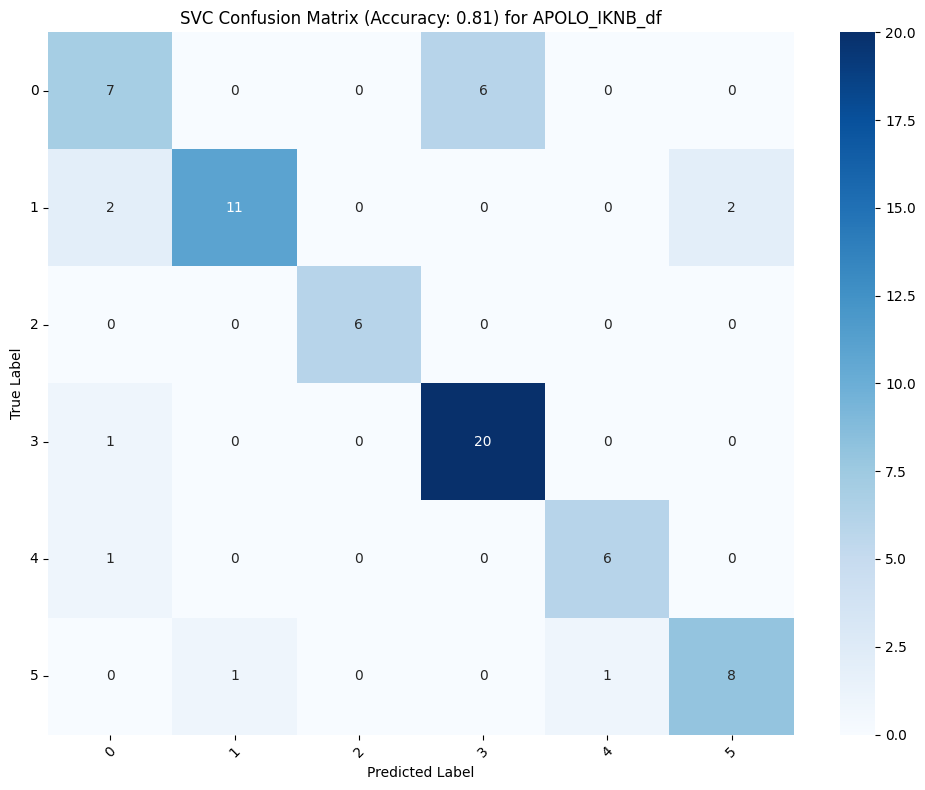

In [ ]:
# --- APOLO_IKNB_df ---
print("--- Running SVC for APOLO_IKNB_df ---")
svc_apolo_iknb = SVC(C=10, gamma='scale', kernel='rbf', probability=True, random_state=42)

try:
    # Training
    svc_apolo_iknb.fit(X_apolo_iknb_res, y_apolo_iknb_res)

    # Predict
    y_apolo_iknb_pred = svc_apolo_iknb.predict(X_apolo_iknb_test_svd)

    # Evaluation
    acc_apolo_iknb = accuracy_score(y_apolo_iknb_test, y_apolo_iknb_pred)
    print(f"✅ Akurasi pada data testing (15%) for APOLO_IKNB_df: {acc_apolo_iknb:.4f}")

    train_accuracy_apolo_iknb = accuracy_score(y_apolo_iknb_res, svc_apolo_iknb.predict(X_apolo_iknb_res))
    print(f"✅ Akurasi pada data pelatihan (85%) for APOLO_IKNB_df: {train_accuracy_apolo_iknb:.4f}")

    print("\n📄 Classification Report for APOLO_IKNB_df:\n", classification_report(y_apolo_iknb_test, y_apolo_iknb_pred))

    # Confusion Matrix
    labels_apolo_iknb = sorted(list(np.unique(y_apolo_iknb_test)))
    cm_apolo_iknb = confusion_matrix(y_apolo_iknb_test, y_apolo_iknb_pred, labels=labels_apolo_iknb)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_apolo_iknb, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels_apolo_iknb, yticklabels=labels_apolo_iknb)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'SVC Confusion Matrix (Accuracy: {acc_apolo_iknb:.2f}) for APOLO_IKNB_df')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"❌ Gagal menjalankan SVC for APOLO_IKNB_df: {e}")


--- Running SVC for EREP_df ---
✅ Akurasi pada data testing (15%) for EREP_df: 0.7857
✅ Akurasi pada data pelatihan (85%) for EREP_df: 0.9991

📄 Classification Report for EREP_df:
               precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       1.00      0.75      0.86         4
           2       0.80      0.67      0.73         6
           3       0.71      0.87      0.78        23
           4       1.00      1.00      1.00         2
           5       1.00      0.64      0.78        11
           6       0.78      0.70      0.74        10
           7       0.75      0.75      0.75         4

    accuracy                           0.79        70
   macro avg       0.85      0.78      0.81        70
weighted avg       0.81      0.79      0.78        70



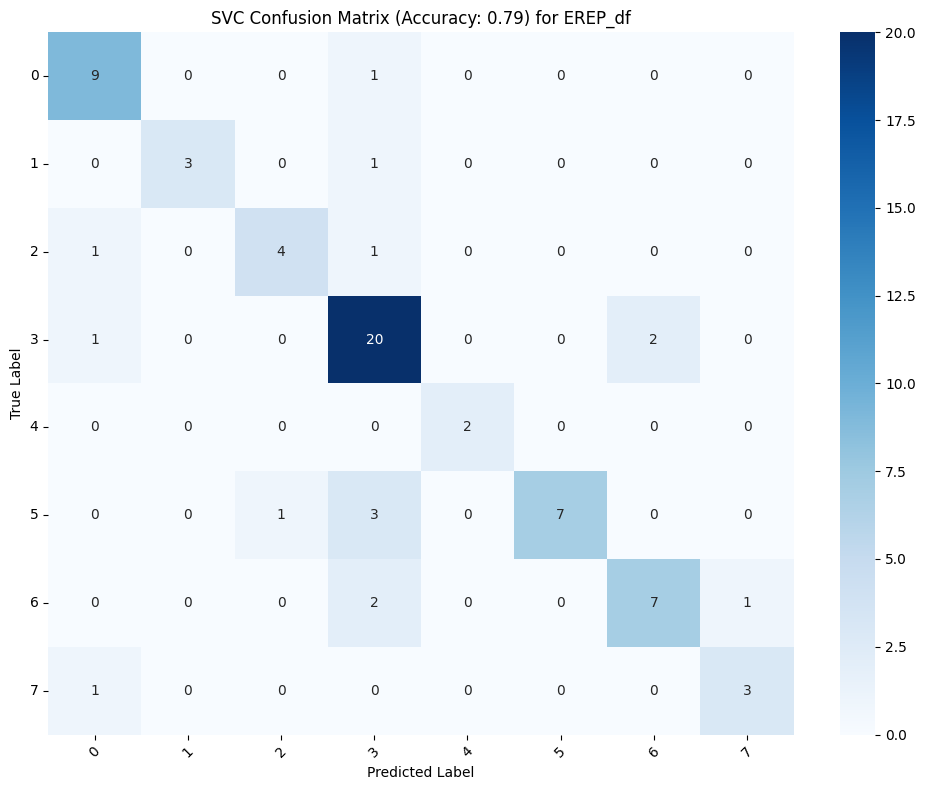

In [ ]:
# --- EREP_df ---
print("\n--- Running SVC for EREP_df ---")

svc_erep = SVC(C=10, gamma='scale', kernel='rbf', probability=True, random_state=42)

try:
    # Training
    svc_erep.fit(X_erep_res, y_erep_res)

    # Predict
    y_erep_pred = svc_erep.predict(X_erep_test_svd)

    # Evaluation
    acc_erep = accuracy_score(y_erep_test, y_erep_pred)
    print(f"✅ Akurasi pada data testing (15%) for EREP_df: {acc_erep:.4f}")

    train_accuracy_erep = accuracy_score(y_erep_res, svc_erep.predict(X_erep_res))
    print(f"✅ Akurasi pada data pelatihan (85%) for EREP_df: {train_accuracy_erep:.4f}")

    print("\n📄 Classification Report for EREP_df:\n", classification_report(y_erep_test, y_erep_pred))

    # Confusion Matrix
    labels_erep = sorted(list(np.unique(y_erep_test)))
    cm_erep = confusion_matrix(y_erep_test, y_erep_pred, labels=labels_erep)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_erep, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels_erep, yticklabels=labels_erep)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'SVC Confusion Matrix (Accuracy: {acc_erep:.2f}) for EREP_df')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"❌ Gagal menjalankan SVC for EREP_df: {e}")


--- Running VotingClassifier for SIPEDULI_df ---

===== Voting Classifier for SIPEDULI_df =====
Akurasi: 0.8613138686131386
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8
           2       0.78      0.70      0.74        10
           3       0.50      0.25      0.33         4
           4       1.00      1.00      1.00         8
           5       0.81      0.98      0.89        52
           6       1.00      1.00      1.00         8
           7       0.50      0.33      0.40         3
           8       1.00      1.00      1.00         8
           9       0.00      0.00      0.00         2
          10       1.00      1.00      1.00         8
          11       0.78      1.00      0.88         7
          12       1.00      0.12      0.22         8
          13       0.67      0.67      0.67         3

    accuracy                           

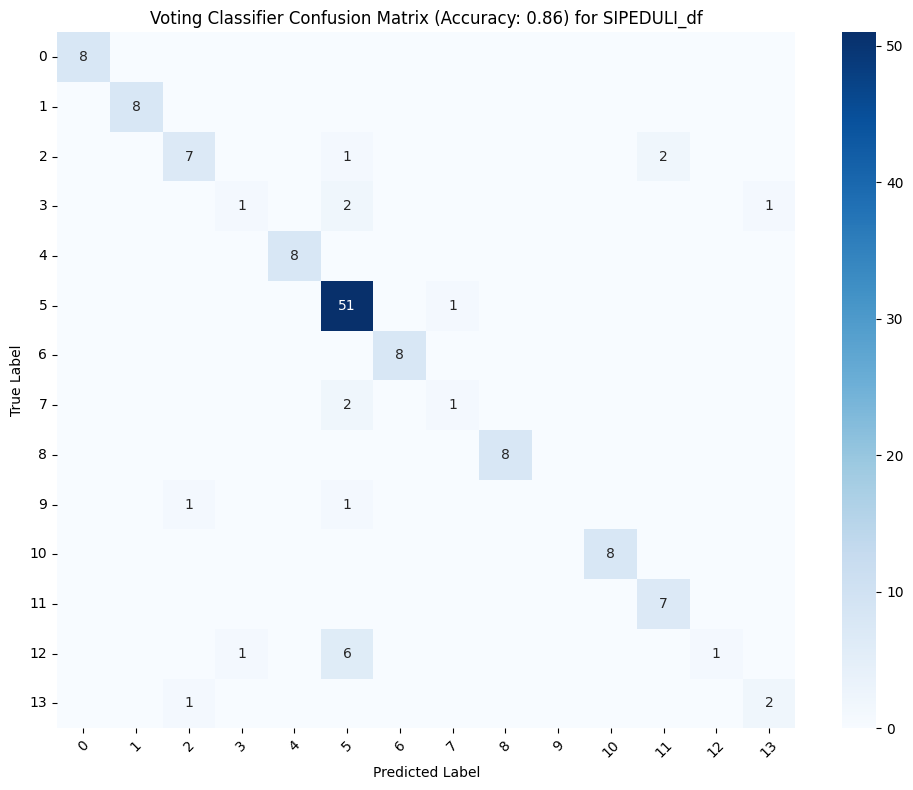

In [ ]:
# --- SIPEDULI_df ---
print("\n--- Running VotingClassifier for SIPEDULI_df ---")

voting_clf_sipeduli = VotingClassifier(
    estimators=[
    ("Extra Trees", ExtraTreesClassifier(n_estimators=200, random_state=42),),
    ("svc", SVC(kernel='rbf', probability=True, random_state=42)),
    ("gradientboost", GradientBoostingClassifier(random_state=42)),
    ('hgb', HistGradientBoostingClassifier(learning_rate=0.05, random_state=42)),
], voting='soft', n_jobs=-1
)

print("\n===== Voting Classifier for SIPEDULI_df =====")
try:
    labels = sorted(list(np.unique(y_sipeduli_test)))
    voting_clf_sipeduli.fit(X_sipeduli_res, y_sipeduli_res)
    y_pred = voting_clf_sipeduli.predict(X_sipeduli_test)

    acc = accuracy_score(y_sipeduli_test, y_pred)
    print("Akurasi:", acc)
    print("Classification Report:\n", classification_report(y_sipeduli_test, y_pred))

    cm = confusion_matrix(y_sipeduli_test, y_pred, labels=labels)
    cm_display = np.where(cm == 0, '', cm)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=cm_display, fmt='', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Voting Classifier Confusion Matrix (Accuracy: {acc:.2f}) for SIPEDULI_df')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"❌ Gagal menjalankan Voting Classifier: {e}")


--- Running VotingClassifier for SLIK_df ---
✅ Akurasi pada data testing (20%) for SLIK_df: 0.8860
✅ Akurasi pada data pelatihan (80%) for SLIK_df: 1.0000

📄 Classification Report for SLIK_df:
               precision    recall  f1-score   support

           0       0.89      0.68      0.77        37
           1       0.93      0.87      0.90        60
           2       0.81      0.92      0.86        50
           3       0.88      0.91      0.89        65
           4       0.93      0.96      0.95        82
           5       0.85      0.88      0.86        32
           6       0.88      0.88      0.88        25

    accuracy                           0.89       351
   macro avg       0.88      0.87      0.87       351
weighted avg       0.89      0.89      0.88       351



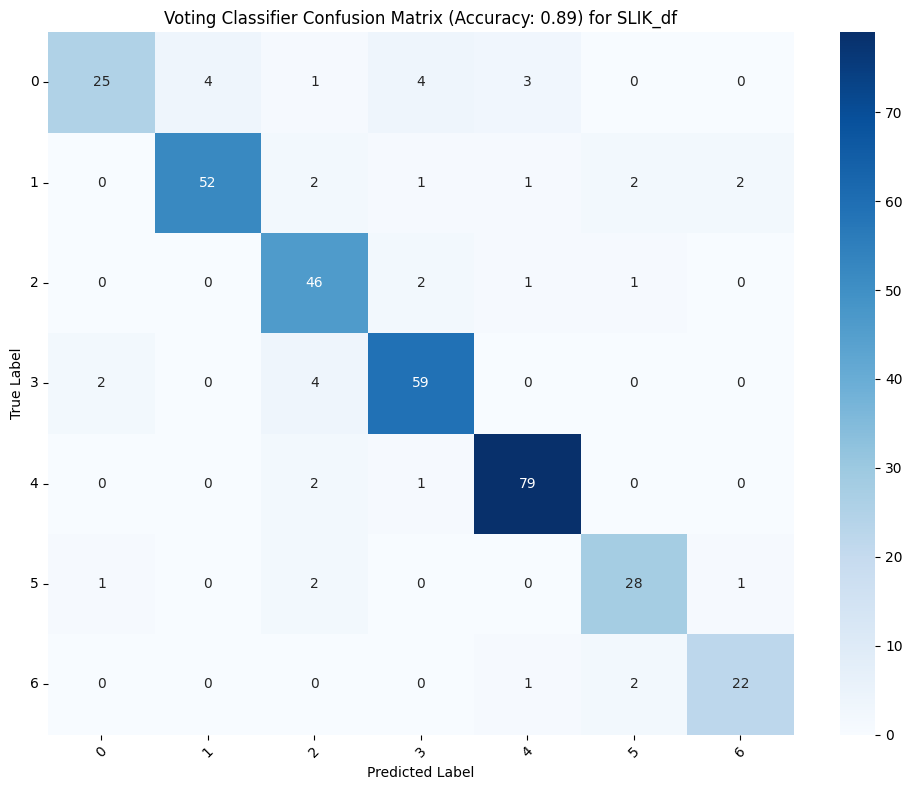

In [ ]:
# --- SLIK_df ---
print("\n--- Running VotingClassifier for SLIK_df ---")
voting_clf_slik = VotingClassifier(estimators=[
    ("SVC", SVC(C=10, gamma='scale', kernel='rbf', probability=True, random_state=42)),
    ("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)),
    ("RandomForest", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=None, min_samples_split=2))
], voting='soft', n_jobs=-1)

try:
    # Training
    voting_clf_slik.fit(X_slik_res, y_slik_res)

    # Predict
    y_slik_pred = voting_clf_slik.predict(X_slik_test_svd)

    # Evaluation
    acc_slik = accuracy_score(y_slik_test, y_slik_pred)
    print(f"✅ Akurasi pada data testing (20%) for SLIK_df: {acc_slik:.4f}")

    train_accuracy_slik = accuracy_score(y_slik_res, voting_clf_slik.predict(X_slik_res))
    print(f"✅ Akurasi pada data pelatihan (80%) for SLIK_df: {train_accuracy_slik:.4f}")

    print("\n📄 Classification Report for SLIK_df:\n", classification_report(y_slik_test, y_slik_pred))

    # Confusion Matrix
    labels_slik = sorted(list(np.unique(y_slik_test)))
    cm_slik = confusion_matrix(y_slik_test, y_slik_pred, labels=labels_slik)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_slik, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels_slik, yticklabels=labels_slik)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Voting Classifier Confusion Matrix (Accuracy: {acc_slik:.2f}) for SLIK_df')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"❌ Gagal menjalankan VotingClassifier for SLIK_df: {e}")


--- Running SVC for APOLO_Perbankan_df ---
✅ Akurasi pada data testing (20%) for APOLO_Perbankan_df: 0.7878
✅ Akurasi pada data pelatihan (80%) for APOLO_Perbankan_df: 1.0000

📄 Classification Report for APOLO_Perbankan_df:
               precision    recall  f1-score   support

           0       0.90      0.93      0.92        41
           1       0.82      0.82      0.82        57
           2       0.65      0.68      0.67        22
           3       0.59      0.53      0.56        19
           4       0.80      0.88      0.84        41
           5       0.81      0.81      0.81        27
           6       0.71      0.81      0.76        37
           7       1.00      0.94      0.97        18
           8       0.77      0.80      0.78        25
           9       0.63      0.56      0.59        34
          10       0.94      0.74      0.83        23

    accuracy                           0.79       344
   macro avg       0.79      0.77      0.78       344
weighted avg    

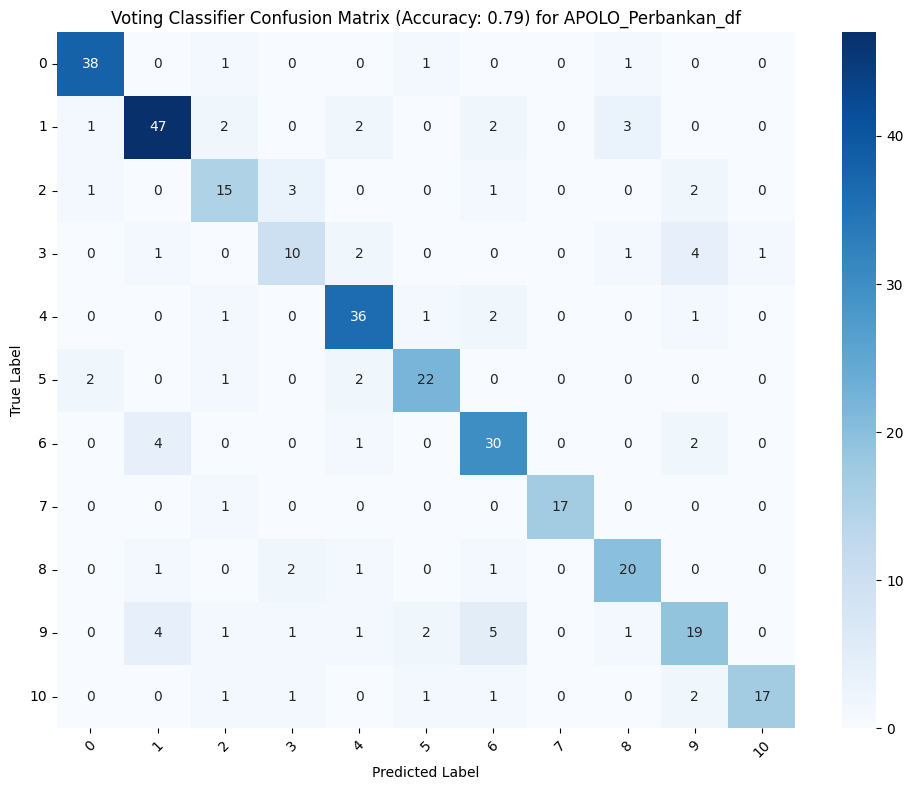

In [ ]:
# --- APOLO_Perbankan_df ---
print("\n--- Running SVC for APOLO_Perbankan_df ---")

svc_apolo_perbankan = SVC(C=10, gamma='scale', kernel='rbf', probability=True, random_state=42)

try:
    # Training
    svc_apolo_perbankan.fit(X_apolo_perbankan_res, y_apolo_perbankan_res)

    # Predict
    y_apolo_perbankan_pred = svc_apolo_perbankan.predict(X_apolo_perbankan_test_svd)

    # Evaluation
    acc_apolo_perbankan = accuracy_score(y_apolo_perbankan_test, y_apolo_perbankan_pred)
    print(f"✅ Akurasi pada data testing (20%) for APOLO_Perbankan_df: {acc_apolo_perbankan:.4f}")

    train_accuracy_apolo_perbankan = accuracy_score(y_apolo_perbankan_res, svc_apolo_perbankan.predict(X_apolo_perbankan_res))
    print(f"✅ Akurasi pada data pelatihan (80%) for APOLO_Perbankan_df: {train_accuracy_apolo_perbankan:.4f}")

    print("\n📄 Classification Report for APOLO_Perbankan_df:\n", classification_report(y_apolo_perbankan_test, y_apolo_perbankan_pred))

    # Confusion Matrix
    labels_apolo_perbankan = sorted(list(np.unique(y_apolo_perbankan_test)))
    cm_apolo_perbankan = confusion_matrix(y_apolo_perbankan_test, y_apolo_perbankan_pred, labels=labels_apolo_perbankan)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_apolo_perbankan, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels_apolo_perbankan, yticklabels=labels_apolo_perbankan)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Voting Classifier Confusion Matrix (Accuracy: {acc_apolo_perbankan:.2f}) for APOLO_Perbankan_df')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"❌ Gagal menjalankan SVC for APOLO_Perbankan_df: {e}")

In [ ]:
import joblib

# Simpan model setiap aplikasi
joblib.dump(svc_apolo_iknb, 'apolo_iknb_model.pkl')
joblib.dump(svc_erep, 'erep_model.pkl')
joblib.dump(voting_clf_sipeduli, 'sipeduli_model.pkl')
joblib.dump(voting_clf_slik, 'slik_model.pkl')
joblib.dump(svc_apolo_perbankan, 'apolo_perbankan_model.pkl')

# Simpan SVD
joblib.dump(svd_apolo_iknb, 'svd_apolo_iknb_model.pkl')
joblib.dump(svd_erep, 'svd_erep_model.pkl')
joblib.dump(svd, 'svd_sipeduli_model.pkl')
joblib.dump(svd_slik, 'svd_slik_model.pkl')
joblib.dump(svd_apolo_perbankan, 'svd_apolo_perbankan_model.pkl')

# Simpan LabelEncoder
joblib.dump(le_apolo_iknb, 'label_encoder_apolo_iknb.pkl')
joblib.dump(le_erep, 'label_encoder_erep.pkl')
joblib.dump(le_sipeduli, 'label_encoder_sipeduli.pkl')
joblib.dump(le_slik, 'label_encoder_slik.pkl')
joblib.dump(le_apolo_perbankan, 'label_encoder_apolo_perbankan.pkl')

# Simpan SentenceTransformer
model_sentence.save('./embedding_model')

## **Klasifikasi dengan Data Baru**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Database.new.xlsx to Database.new.xlsx


In [ ]:
# Load file baru
import io
new_data = pd.read_excel(io.BytesIO(list(uploaded.values())[0]))

# Pastikan kolom penting ada
assert 'Notes' in new_data.columns and 'Closure Product Name' in new_data.columns, "Kolom tidak ditemukan!"

# Hapus baris kosong pada Notes
new_data = new_data.dropna(subset=['Notes'])

# Mapping aplikasi ke model, svd, fungsi cleaning, dan encoder label
app_config = {
    'APOLO IKNB': {
        'model': svc_apolo_iknb,
        'svd': svd_apolo_iknb,
        'clean_func': cleaning_data,
        'encoder': le_apolo_iknb
    },
    'E-Reporting PM dan IKNB': {
        'model': svc_erep,
        'svd': svd_erep,
        'clean_func': cleaning_data_erep,
        'encoder': le_erep
    },
    'SIPEDULI': {
        'model': voting_clf_sipeduli,
        'svd': svd,
        'clean_func': cleaning_data,
        'encoder': le_sipeduli
    },
    'SLIK': {
        'model': voting_clf_slik,
        'svd': svd_slik,
        'clean_func': cleaning_data,
        'encoder': le_slik
    },
    'APOLO Perbankan': {
        'model': svc_apolo_perbankan,
        'svd': svd_apolo_perbankan,
        'clean_func': cleaning_data,
        'encoder': le_apolo_perbankan
    }
}

# Simpan prediksi dari tiap aplikasi
results = []

for app_name, config in app_config.items():
    df_app = new_data[new_data['Closure Product Name'].str.contains(app_name, case=False, na=False)].copy()

    if df_app.empty:
        continue

    # Bersihkan teks
    df_app['Cleaned'] = df_app['Notes'].apply(config['clean_func'])

    # Embedding dan reduksi dimensi
    embeddings = model_sentence.encode(df_app['Cleaned'].tolist())
    reduced = config['svd'].transform(embeddings)

    # Prediksi
    pred_labels = config['model'].predict(reduced)
    df_app['Predicted_Topic_Label'] = pred_labels

    df_app['Predicted_Topic'] = config['encoder'].inverse_transform(pred_labels)

    results.append(df_app)

# Gabungkan semua hasil
final_df = pd.concat(results, ignore_index=True)

# Simpan hasil ke Excel
final_df.to_excel("hasil_klasifikasi_topik.xlsx", index=False)
files.download("hasil_klasifikasi_topik.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>